# Introduction to Inversion 

## RMS and Inverval velocity 

The RMS velocity is related to the interval velocity via 

$$V^2_{rms}(t_j) = \frac{1}{t_j} \int_0^{t_{max}} v^2_{int}(u) du$$

where 
- $v_{int}$ is the interval velocity 
- $V^2_{rms}$ is the RMS velocity 
- $H$ is the heavyside step function 
- $t$ is time

The analytic inverse is given by 

$$v_{int} = V_{rms}(t) \left(1 + \frac{2 t V'_{rms}(t)}{V_{rms}(t)}\right)^{1/2}$$

In order to work with these equations, we will pick a function for $v_{int}$ that we can integrate: 

$$v_{int} = v_0 + a \sin(2\pi f t)$$
$$\quad = v_0 + a \sin(\omega t)$$

## Goals
- figure out what $V_{rms}$ (can use sympy or Wolfram Alpha) 
- use finite differences to recover $v_{int}$ from $V_{rms}$ 
- explore principles of non-uniqueness for this problem 


In [34]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

In [2]:
def interval_velocity_analytic(t, v0, a, omega):
    return v0 + a * np.sin(omega*t) 

In [3]:
v0 = 2000 
a = 50
f = 2
omega = 2 * np.pi *f

In [4]:
n_times = 200 
tmax = 2

t = np.linspace(0, tmax, n_times) 

In [5]:
vint_analytic = interval_velocity_analytic(t, v0, a, omega)

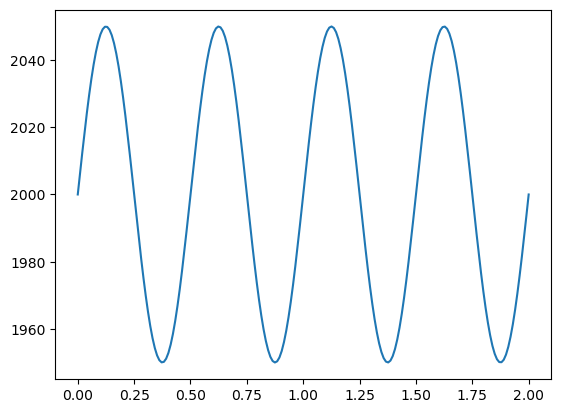

In [6]:
plt.plot(t, vint_analytic)

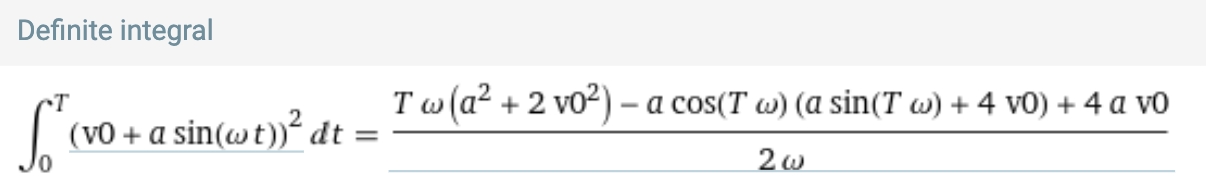

In [7]:
def rms_velocity_analytic(t, v0, a, omega):
    
    inds_nonzero = t > 0 # in general a small number 
    
    vrms = np.zeros_like(t)  # np.zeros(len(t))
    
    vrms[inds_nonzero] = np.sqrt((
        omega * (a**2 + 2 * v0**2)
        - a / t[inds_nonzero] * np.cos(omega * t[inds_nonzero]) * (a * np.sin(omega*t[inds_nonzero]) + 4 * v0)
        + 4 * a / t[inds_nonzero] * v0
    ) / (2 * omega))
    
    vrms[~inds_nonzero] = v0
    
    return vrms

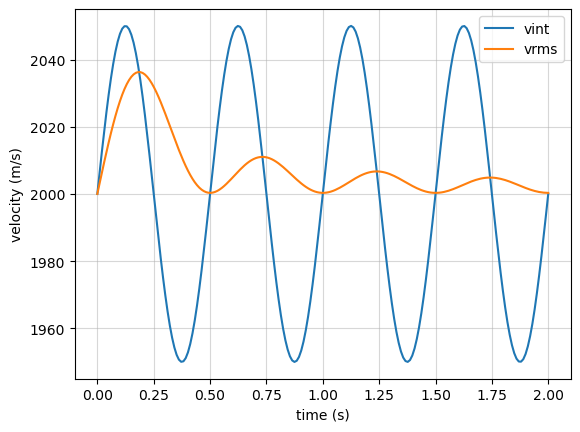

In [8]:
fig, ax = plt.subplots(1, 1) 

vrms = rms_velocity_analytic(t, v0, a, omega)

ax.plot(t, vint_analytic, label="vint")
ax.plot(t, vrms, label="vrms")
ax.legend()
ax.set_xlabel("time (s)")
ax.set_ylabel("velocity (m/s)")
ax.grid(alpha=0.5)

$$v_{int} = V_{rms}(t) \left(1 + \frac{2 t V'_{rms}(t)}{V_{rms}(t)}\right)^{1/2}$$

In [9]:
vrms = rms_velocity_analytic(t, v0, a, omega)

dt = np.diff(t)
dv = np.diff(vrms)

dv_dt = dv / dt
dv_dt = np.r_[0, dv_dt]

In [12]:
vint_rec = vrms * (1 + (2*t*dv_dt)/vrms)**0.5

In [14]:
def compute_vint_from_vrms(t, vrms): 
    dt = np.diff(t)
    dv = np.diff(vrms)

    dv_dt = dv / dt
    dv_dt = np.r_[0, dv_dt]
    
    return vrms * (1 + (2*t*dv_dt)/vrms)**0.5

In [15]:
vint_2 = compute_vint_from_vrms(t, vrms)

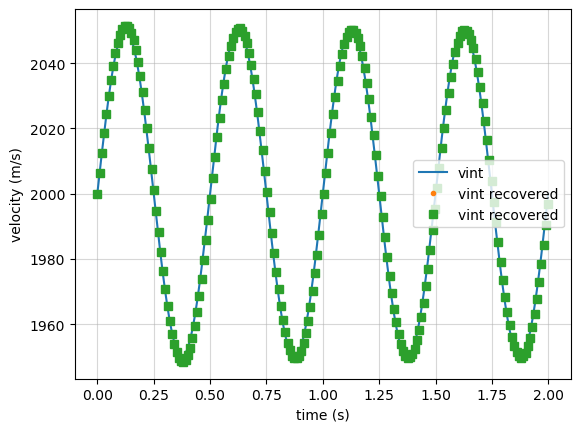

In [16]:
fig, ax = plt.subplots(1, 1) 

ax.plot(t, vint_analytic, label="vint")
ax.plot(t, vint_rec, ".", label="vint recovered")
ax.plot(t, vint_2, "s", label="vint recovered")
ax.legend()
ax.set_xlabel("time (s)")
ax.set_ylabel("velocity (m/s)")
ax.grid(alpha=0.5)

# Inversion with a finite number of accurate data

In [78]:
decimate = 7

t_obs = t[::decimate]
vrms_obs = vrms[::decimate]

vrms_obs = vrms_obs + np.random.randn(len(t_obs))

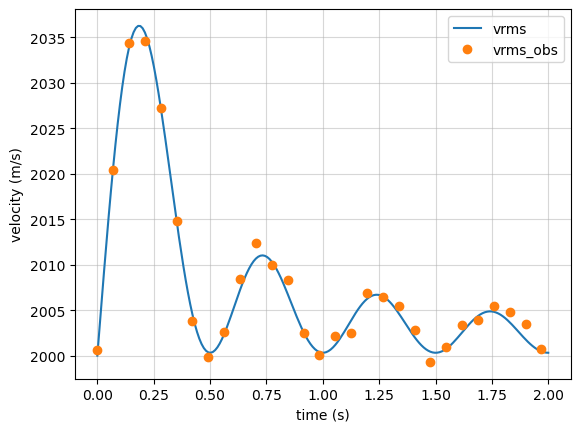

In [79]:
fig, ax = plt.subplots(1, 1) 

ax.plot(t, vrms, label="vrms")
ax.plot(t_obs, vrms_obs, "o", label="vrms_obs")
ax.legend()
ax.set_xlabel("time (s)")
ax.set_ylabel("velocity (m/s)")
ax.grid(alpha=0.5)

In [80]:
vint_decimated = compute_vint_from_vrms(t_obs, vrms_obs)

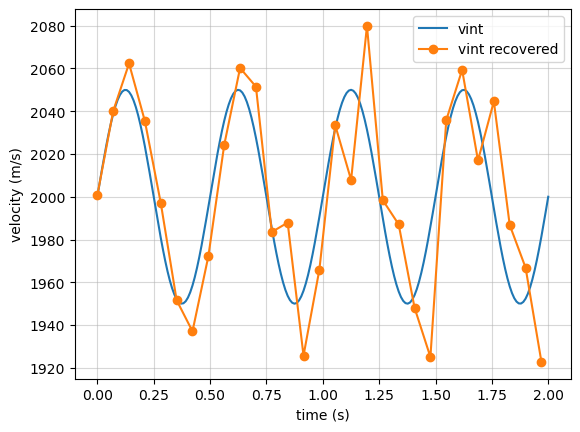

In [81]:
fig, ax = plt.subplots(1, 1) 

ax.plot(t, vint_analytic, label="vint")
ax.plot(t_obs, vint_decimated, "-o", label="vint recovered")
ax.legend()
ax.set_xlabel("time (s)")
ax.set_ylabel("velocity (m/s)")
ax.grid(alpha=0.5)

# Interpolate to a finer grid

In [64]:
# from scipy.interpolate import interp1d

# >>> import numpy as np
# >>> import matplotlib.pyplot as plt
# >>> from scipy import interpolate
# >>> x = np.arange(0, 10)
# >>> y = np.exp(-x/3.0)
# >>> f = interpolate.interp1d(x, y)

# >>> xnew = np.arange(0, 9, 0.1)
# >>> ynew = f(xnew)   # use interpolation function returned by `interp1d`
# >>> plt.plot(x, y, 'o', xnew, ynew, '-')
# >>> plt.show()

In [82]:
linear_interpolation = interp1d(t_obs, vrms_obs, kind="linear", fill_value="extrapolate")
spline_interpolation = interp1d(t_obs, vrms_obs, kind="cubic", fill_value="extrapolate")

In [83]:
vrms_linear = linear_interpolation(t) 
vrms_spline = spline_interpolation(t) 

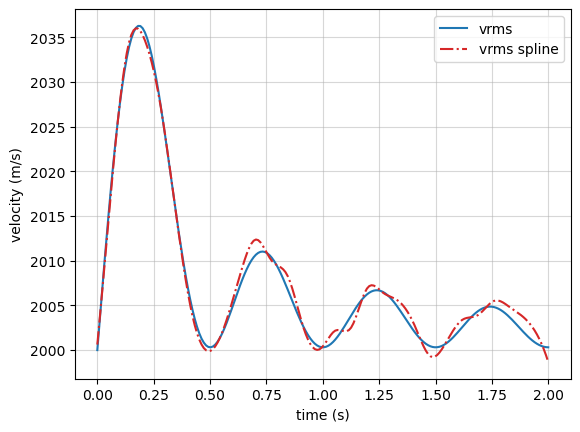

In [84]:
fig, ax = plt.subplots(1, 1) 

ax.plot(t, vrms, color="C0", label="vrms")
# ax.plot(t_obs, vrms_obs, "o", color="C1", label="vrms_obs")
# ax.plot(t, vrms_linear, '--', color="C2", label="vrms linear") 
ax.plot(t, vrms_spline, '-.', color="C3", label="vrms spline") 
ax.legend()
ax.set_xlabel("time (s)")
ax.set_ylabel("velocity (m/s)")
ax.grid(alpha=0.5)

In [85]:
vint_linear = compute_vint_from_vrms(t, vrms_linear)
vint_spline = compute_vint_from_vrms(t, vrms_spline)

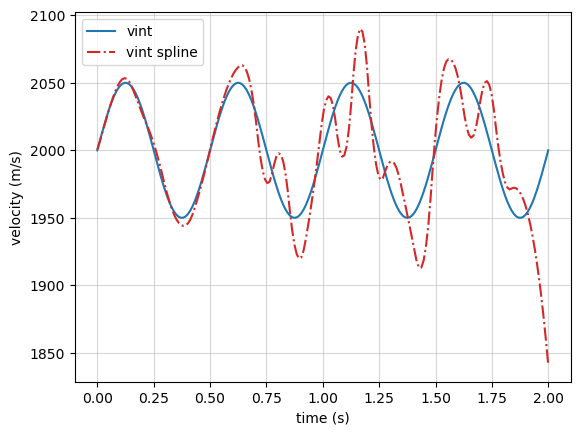

In [86]:
fig, ax = plt.subplots(1, 1) 

ax.plot(t, vint_analytic, color="C0", label="vint")
# ax.plot(t_obs, vint_decimated, "-o", color="C1", label="vint recovered")
# ax.plot(t, vint_linear, "--", color="C2", label="vint linear")
ax.plot(t, vint_spline, "-.", color="C3", label="vint spline")
ax.legend()
ax.set_xlabel("time (s)")
ax.set_ylabel("velocity (m/s)")
ax.grid(alpha=0.5)